# Programming Assignment 3: Low Rank Matrix Approximation

**Assignment submission:** This assignment is to be uploaded as both a .ipynb file and a converted .pdf file **via Gradescope**. You can submit as often as you need, but only the last submission is graded, and submissions made after the deadline may incur a late penalty depending on your remaining free late hours.

## Assignment Instructions

**Programming assignments will be written in Python.** For more help with using Python, please refer to the pre-work resources in our syllabus and to the notebooks from Precept 1 (python primer) and Precept 2 (linear regression using the `numpy` library) and Precept 6 (using the `pandas` library).

* Make sure that you run all cells before submitting.

* Verify that you have all assignment files copied over:
  1. `cos324s25_pa3.ipynb` - Assignment Notebook
  2. `ratings.csv` - Data file used in Part 2
  3. `movies.csv` - Data file used in Part 2

* Throughout this assignment, we ask you to avoid using loops wherever possible. Read the comments before each function carefully and note whenever we indicate that "*Your implementation must be vectorized. You may not use a python loop*."

* **We strongly suggest that you run Jupyter Notebook using [MyAdroit](https://myadroit.princeton.edu). *We will only support running Jupyter Notebook on MyAdroit in office hours*.** We will not be able to help you with issues/instructions regarding local Python environments.
* The instructions for the assignments will provide some guidance on finding useful functions for completing the assignment, but **it will be up to you to search for the exact documentation for specific functions**. Learning to search for helpful information is an important skill for programming.
* **We expect your code to be readable and interpretable**, with meaningful variable names and comments that help us understand your code. Please refer to [PEP 8](https://www.python.org/dev/peps/pep-0008/) for guidance.
* **Consulting course staff (e.g. TAs, UCAs) and/or other students from this course is allowed.** Please refer to our collaboration policy for guidance on what is and isn't acceptable.
  * **List your collaborators for each problem in a collaboration statement in the next cell.**
  * You should also **cite all sources** you consulted per problem if they aren't a required or optional course reading. You can do this using a Python comment: `# Consulted this source: ...`.
* **You may not use unauthorized packages or libraries.** If you use code from outside sources or past/other academic work, it must be targeted toward a single and minute purpose (e.g. one or two lines of code for changing the scale of plot axes) and not make up a significant portion of your submission. If you are copying a block of code, you are likely in violation of this rule.

## Collaboration statement

List all collaborators by name, including other students and/or course staff (e.g. TAs, UCAs). If you collaborated with no one on this assignment, write the following: ``"I did not collaborate with anyone on this assignment."``

Elif Selin Kozanoglu

## Overview

In this assignment, we will practice implementing and applying low-rank approximation of matrices, which is useful for finding hidden relationships that might not be apparent from high-dimensional data.

<ins>Format of this PA:<ins>
1. Implement Low Rank Matrix Approximation (LORMA) (ACT 1-6)
2. Perform movie recommendation using LORMA (ACT 7-10)
    * For this part, you will use the `ratings.csv` and `movies.csv` files provided as part of the assignment files.

<hr style="border:3px solid blue"> </hr>

# **Part 1: Implementing Low-Rank Matrix Approximation (LORMA)**

### Formal definition and notation

In this assignment you will be required to approximate a partially observed (typically) large matrix using a product of low rank matrices. Let us recap the ingredients of low rank matrix approximation:  <p>

- Observed matrix $\mathsf{M}$ of size $m \times n$ with real valued entries and missing values <p>
    
- Low rank matrices $\mathsf{A}$ of size $m \times k$ and $\mathsf{B}$ of size $k \times n$ <p>
    
- We would like to find $\mathsf{A}, \mathsf{B}$ such that $\mathsf{M} \approx \mathsf{A} \mathsf{B}$. We will denote $\hat{\mathsf{M}} = \mathsf{A}\mathsf{B}$ <p>
    
Let $\Omega$ denote the set of entries $(i,j)$ where we know the value of $\mathsf{M}_{ij}$. We are going to measure the goodness of our approximation using the squared error at entries $(i,j)$ in $\Omega$ (i.e., at observed entries of $\mathsf{M}$). Therefore the loss is,
$$ L = \frac{1}{|\Omega|} \sum_{(i,j)\in \Omega} \! \big(\mathsf{M}_{ij} -  \hat{\mathsf{M}}_{ij}\big)^2 ~. $$

#### ACT1: Implement average squared loss function (8 pts)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Given M, M_approx, O, return the average squared loss over the observed entries.
#
# parameters
# M:        m x n 2-D numpy array
#           containing the observed entries (with arbitrary values in the unobserved entries)
#
# M_approx: m x n 2-D numpy array
#           representing the low-dimensional approximation
#
# O:        m x n 2-D numpy array
#           containing 0 if the entry is unobserved and 1 if the entry is observed in M.
#           O tells you which entries in M were observed (corresponds to \Omega in the equations above)
#
# output
# loss:     average of squared loss over observed entries
#
# NOTE: No loops please! Your implementation must be vectorized. You may not use a python loop
def loss(M, M_approx, O):
    ### ACT1: add your code here
    
    # pull observed error entries
    M_error = (M - M_approx)[O == 1]

    # compute avg squared loss
    loss = np.mean(M_error ** 2)

    return loss

# The following functions checks if your implementation of loss() is correct
# There's no need to understand it
def check_loss():
    M = np.array([[2, 4, 1], [1, -3, 1]])
    M_approx = np.zeros((2, 3))
    O = np.array([[1, 0, 0], [0, 1, 1]])
    answer = 14 / 3
    output = loss(M, M_approx, O)
    assert(np.isclose(answer, output))
    print("Function {} is working fine!".format('loss()'))

check_loss()

Function loss() is working fine!


<hr style="border:3px solid blue"> </hr>


### Normalization of M

As the initial prediction of $\hat{\mathsf{M}}$ is likely to have entries following a standard normal distribution and we use the squared error as the sole loss, it is good practice for us to normalize $\mathsf{M}$ prior to the learning process. This means that we will preprocess matrix $\mathsf{M}$ so the average over its observed entries is $0$ and the standard deviation is 1. Then the empirical distribution of its entries resembles a standard normal distribution.   

Mathematically speaking, let us normalize $\mathsf{M}$ such that,
$$\sum_{(i,j)\in \Omega} \mathsf{M}_{ij} = 0 ~ \text{ and } ~ \frac{1}{|\Omega|} \sum_{(i,j)\in \Omega} \mathsf{M}^2_{ij} = 1 ~ .$$

We first need to calculate $\mu$ and $\sigma$, the mean and standard deviation respectively of the observed entries in $\mathsf{M}$:
$$\mu = \frac{1}{|\Omega|}\sum_{(i,j)\in O}\mathsf{M}_{ij} ~~ \text{ and } ~~ \sigma = \sqrt{\frac{1}{|\Omega|} \sum_{(i,j)\in \Omega} (\mathsf{M}_{ij} - \mu)^2}.$$

Performing the transformation $\mathsf{M} \mapsto (\mathsf{M} - \mu) / \sigma$ normalizes the matrix $\mathsf{M}$.

**Implementation note:** The function `get_normalized_matrix` should **not mutate** any of its parameters. You should **make a copy** of the relevant parameter(s) (i.e. using `np.copy`) and make changes to the copied variable(s).

#### ACT2: Return the normalized version of M (8 pts)


In [2]:
# Given M, O, return the normalized version of M
#
# parameters
# M:        m x n 2-D numpy array
#           containing the observed entries (with arbitrary values in the unobserved entries)
#
# O:        m x n 2-D numpy array
#           containing 0 if the entry is unobserved and 1 if the entry is observed in M.
#           O tells you which entries in M were observed (corresponds to \Omega in the equations above)
#
# output
# M:        m x n 2-D numpy array
#           normalized copy of the input matrix M
#
# NOTE: No loops please! Your implementation must be vectorized. You may not use a python loop
def get_normalized_matrix(M, O):
    ### ACT2: add your code here
    Mn = np.copy(M) # copies M

    # observed entries in M
    M_obs = M[O == 1]

    # calculate mean
    mu = np.mean(M_obs)

    # calculate stdev
    sigma = (np.mean((M_obs - mu) ** 2)) ** 0.5

    # normalize observed entries of matrix M 
    Mn[O == 1] = (M_obs - mu) / sigma

    return Mn

# The following functions checks if your implementation of get_normalized_matrix() is correct
# There's no need to understand it
def check_normalization():
    M = np.random.rand(10, 3)
    O = (np.random.rand(10, 3) > 0.5) + 0
    Mn = get_normalized_matrix(M, O)
    assert(abs(np.sum(M * O)) > 1e-6)
    assert(abs(np.sum(Mn * O)) < 1e-6)
    assert(abs(np.sum(Mn**2 * O) / np.sum(O) - 1) < 1e-6)
    print("Function {} is working fine!".format('get_normalized_matrix()'))

check_normalization()

Function get_normalized_matrix() is working fine!


<hr style="border:3px solid blue"> </hr>


## Low Rank Matrix Approximation (LORMA)

We are now ready to build a low rank approximation (abbreviated as *LORMA*) of the form,
$$
\mathsf{M} \approx \hat{\mathsf{M}} = \mathsf{A} \mathsf{B}  ~ .
$$
For brevity we refer to this model as *LORMA*. Note that once we established the approximating matrix $\hat{\mathsf{M}}$ we can reuse the same function **loss** from above.

#### ACT3: Implement LORMA's prediction (3 pts)

In [3]:
# Given A, B, the low-rank matrices, calculate and return M_approx (M hat above)
#
# parameters
# A:        m x k 2-D numpy array
# B:        k x n 2-D numpy array
#
# output
# M_approx: m x n 2-D numpy array
#
# NOTE: No loops please! Your implementation must be vectorized. You may not use a python loop
# NOTE: Your implementation should be very simple, don't overthink it!
def lorma(A, B):
    ### ACT3: add your code here

    # calculate M approx from A and B
    M_approx = A @ B

    return M_approx

<hr style="border:3px solid blue"> </hr>


### Gradient of LORMA

Next we need to implement the gradient of the LORMA model. The gradient should have the same structure as the parameters of our LORMA model, which are A (shape $m \times k$) and B (shape $k \times n$).

To get the gradient to A, we apply chain rule for matrix differentiation as:
$$
\frac{dL}{d \mathsf{A}} = \frac{d L}{d \hat{\mathsf{M}}} \cdot \frac{d \hat{\mathsf{M}}}{d \mathsf{A}}
$$
where $\frac{dL}{d \hat{\mathsf{M}}}$ returns a matrix of a shape of $m \times n$ with its entries:
$$
\left(\frac{dL}{d \hat{\mathsf{M}}}\right)_{ij} =
                \begin{cases}
                \frac{2}{|\Omega|}(\hat{\mathsf{M}}_{ij} - \mathsf{M}_{ij}) & \text{if } (i,j)\in \Omega \\
                0 & \text{otherwise}
                \end{cases}
$$
and
$$
\frac{d \hat{\mathsf{M}}}{d \mathsf{A}} = \mathsf{B}^\top
$$
returns a matrix of shape $n \times k$. Note "$\cdot$" denotes the matrix multiplication.


Likewise, to get the gradient with respect to B, we have
$$
\frac{dL}{d \mathsf{B}} = \frac{d \hat{\mathsf{M}}}{d \mathsf{B}}  \cdot  \frac{dL}{d \hat{\mathsf{M}}} ~~~~~~\text{where}~~~~~  \frac{d \hat{\mathsf{M}}}{d \mathsf{B}} = \mathsf{A}^\top
$$

#### ACT4: Implement LORMA gradient (10 pts)

In [4]:
# Given M, O, A, B return dL/dA, dL/dB.
#
# parameters
# M:        m x n 2-D numpy array
#           containing the observed entries (with arbitrary values in the unobserved entries)
#
# O:        m x n 2-D numpy array
#           containing 0 if the entry is unobserved and 1 if the entry is observed in M.
#           O tells you which entries in M were observed (corresponds to \Omega in the equations above)
#
# A:        m x k 2-D numpy array
# B:        k x n 2-D numpy array
#
# output
# dL/dA:    m x k 2-D numpy array
# dL/dB:    k x n 2-D numpy array
#
# NOTE: No loops please! Your implementation must be vectorized. You may not use a python loop
def lorma_grad(M, O, A, B):
    ### ACT4: add your code here
    # calculate M_approx
    M_approx = lorma(A, B)

    # create matrix of all zeros with shape of M
    dLdM = np.zeros_like(M)

    # calculate dL/dM at observed copies of M
    dLdM[O == 1] = (2 / np.sum(O)) * (M_approx[O == 1] - M[O == 1]) # leaves gradient of non-observed at 0

    # calculate dL/dA = dl/dM * dM/dA = dL/dM * BT
    dA = dLdM @ B.T

    # calculate dL/dB = dM/dB * dl/dM = AT * dL/dM
    dB = A.T @ dLdM

    return dA, dB

<hr style="border:3px solid blue"> </hr>


### Initialization of LORMA

<p>

<font size=3>
    
Before we start learning using GD, we need to setup an initial state of $\mathsf{A}$ and $\mathsf{B}$ for estimating $\hat{\mathsf{M}}$. Recall we normalized $\mathsf{M}$ such that
$$\sum_{(i,j) \in \Omega} \mathsf{M}_{ij} = 0 ~ \text{ and } ~ \frac{1}{|\Omega|} \sum_{(i,j)\in \Omega} \mathsf{M}^2_{ij} = 1 ~ .$$
We would like to make sure that the similar properties hold for $\hat{\mathsf{M}}$.
<br><br>

More specifically, we adopt random initialzation of the entries in $\mathsf{A}$ and $\mathsf{B}$ followed by a normalization process to make $\hat{\mathsf{M}}$ satisfy the following properties:  
1. Zero mean, i.e., $\sum_{(i,j)\in \Omega} \hat{\mathsf{M}}_{ij} = 0$:
    
  We can write $\hat{\mathsf{M}}_{ij} = \mathbf{a}_i \cdot \mathbf{b}_j$ where $\mathbf{a}_i$ and $\mathbf{b}_j$ are the $i$-th row & $j$-th column of $\mathsf{A}$ and $\mathsf{B}$ respectively. Since $\mathsf{A}$ and $\mathsf{B}$ are completely random the probability that $\mathbf{a}_i\cdot \mathbf{b}_j$ is small is pretty high so we can assume that $\sum_{i,j} \hat{\mathsf{M}}_{ij} = \sum_{i,j} \mathbf{a}_i \cdot \mathbf{b}_j \approx 0$.


2. Less than or equal to unit variance, i.e., $\frac{1}{mn} \sum_{i,j} \hat{\mathsf{M}}_{ij}^2  \leq 1$:    
    
  It suffices to have each $|\hat{\mathsf{M}}_{ij}|\leq 1$ to satisfy the above condition.
  We can guarantee this by normalizing each $\mathbf{a}_i$ and $\mathbf{b}_j$ so they have a unit norm:
$$
    \mathbf{a}_i \mapsto \frac{\mathbf{a}_i}{\|\mathbf{a}_i\|} ~ \text{ and } ~
    \mathbf{b}_j \mapsto \frac{\mathbf{b}_j}{\|\mathbf{b}_j\|} ~ .
$$
Once the norm of all vectors $\mathbf{a}_1,\ldots,\mathbf{a}_k,\mathbf{b}_1,\ldots,\mathbf{b}_k$ is $1$ the inner products $\mathbf{a}_i\cdot \mathbf{b}_j$ are in $[-1,1]$, which tells us $| \hat{\mathsf{M}}_{ij}| \leq 1$. This property is known as Cauchy's inequality which is typically presented as,
$| \mathbf{a} \cdot \mathbf{b} | \leq \| \mathbf{a} \| \| \mathbf{b} \|$.

</font>


**NOTES**

*   The random values should be in a normal distribution with mean 0 and variance 1
*   For randomizing and creating arrays A and B, you can use any function under the `np.random` library that produces the required unit variance gaussian.





#### ACT5: Implement LORMA initialization (8 pts)

In [5]:
# Given m, n, k, initialize and normalize A, B as per the guideline above
#
# parameters
# m, n, k:  shapes for A, B
#
# output
# A:        m x k 2-D numpy array
# B:        k x n 2-D numpy array
#
# NOTE: No loops please! Your implementation must be vectorized. You may not use a python loop
def lorma_init(m, n, k):
    # ACT5a: intialize A, B using a zero-mean unit-variance Gaussian (ie a normal distribution with mean 0 and variance 1) per entry
    A = np.random.normal(0, 1, (m, k))
    B = np.random.normal(0, 1, (k, n))
    # ACT5b: normalize the rows of A and columns of B
    A = A / np.linalg.norm(A, axis = 1, keepdims = True)
    B = B / np.linalg.norm(B, axis = 0, keepdims = True)
    return A, B

# The following code is to check your implementation
# There's no need to understand it
def check_lorma_init():
    A, B = lorma_init(10, 7, 3)
    assert(np.linalg.norm(np.diag(A @ A.T) - np.ones(10), 1) < 1e-6)
    assert(np.linalg.norm(np.diag(B.T @ B) - np.ones(7), 1) < 1e-6)
    print("Function {} is working fine!".format('lorma_init()'))
    return

check_lorma_init()

Function lorma_init() is working fine!


<hr style="border:3px solid blue"> </hr>

### Finally, it is time to use gradient descent (GD) to learn a LORMA model

    
Details for implementation:
1. Unpack parameters in params (code provided)
2. Call `get_normalized_matrix()` to get the normalized version of M.
3. Initialize A, B by calling `lorma_init()`
4. Create a list `losses` which will record the approximation error at every 10 epochs. Store the initial loss as `losses[0]`
5. Within the main loop
- Call `lorma_grad()` to get new gradients `dA` for `A` and `dB` for `B`
- Perform gradient step with the appropriate learning rate from the provided **list** `etas`
- Every 10 epochs, do the following
    - Call the `loss()` function to calculate and append the current loss to `losses`
    - Print the most recent current loss. Your print statements should be of the following format, where the loss is rounded to 4 decimal places (recall that `arr[-1]` returns the last element in a list and `x.round(4)` rounds a number to 4 decimal places):
      ```
      Epoch 0: ____
      Epoch 10: ____
      Epoch 20: ____
      ...
      ```

#### ACT6: Implement GD for LORMA model (13 pts)

In [6]:
# Given M, O, params, run gradient descent to compute the low-dimensional
# approximation A, B and losses, the list of approximation errors
#
# parameters
# M:        m x n 2-D numpy array
#           containing the observed entries (with arbitrary values in the unobserved entries)
#
# O:        m x n 2-D numpy array
#           containing 0 if the entry is unobserved and 1 if the entry is observed in M.
#           O tells you which entries in M were observed (corresponds to \Omega in the equations above)
#
# params:   tuple of 3 parameters (k, num_epochs, etas)
#.          k is the rank of your LORMA model
#           num_epochs is the number of epochs to run gradient descent
#           etas is a list of floats, with the learning rate for each epoch
#           len(etas) = num_epochs
#
# output
# A:        m x k 2-D numpy array
# B:        k x n 2-D numpy array
# losses:   list of approximation errors evaluated at every 10 epochs
def lorma_learn(M, O, params):
    k, num_epochs, etas = params
    ### ACT6: add your code here
    m, n = M.shape

    # get normalized matrix 
    Mn = get_normalized_matrix(M, O)

    # initialize A, B and list to store losses
    A, B = lorma_init(m, n, k)
    losses = []

    # store and print initial loss
    M_approx = lorma(A, B) 
    losses.append(loss(Mn, M_approx, O))    
    print("Epoch 0:", losses[-1].round(4))

    for e in range(num_epochs):
        # get gradients 
        dA, dB = lorma_grad(Mn, O, A, B)

        # perform A, B update with learning rate in etas
        A = A - etas[e] * dA
        B = B - etas[e] * dB

        # calculate and store loss at every 10th epoch
        if (e + 1) % 10 == 0: 
            current_loss = loss(Mn, lorma(A, B), O)
            losses.append(current_loss)

            # print loss
            print("Epoch", e+1, ":", losses[-1].round(4))
        
    return A, B, losses

Epoch 0: 1.1611
Epoch 10 : 1.0062
Epoch 20 : 0.8719
Epoch 30 : 0.7091
Epoch 40 : 0.5176
Epoch 50 : 0.3393
Epoch 60 : 0.2098
Epoch 70 : 0.1283
Epoch 80 : 0.0801
Epoch 90 : 0.0522
Epoch 100 : 0.0362


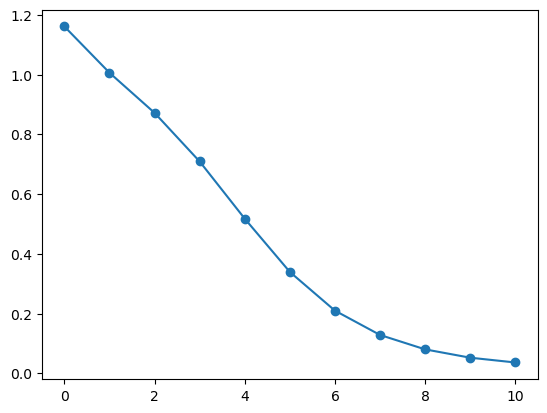

In [7]:
m, n, k = 100, 40, 5
rand_seed = 10
np.random.seed(rand_seed)

def check_lorma_learn():
    from numpy.random import binomial, randn, uniform
    mockA, mockB = uniform(1, 2, (m, k)), uniform(-2, -1, (k, n))
    M = mockA @ mockB + 0.01 * np.random.randn(m, n)
    O = binomial(1, 0.5, size=M.shape)
    num_epochs = 100
    etas = 2.0 * np.ones(num_epochs)
    params = k, num_epochs, etas
    A, B, losses = lorma_learn(M, O, params)
    plt.plot(losses, '-o')
    return M, A, B

M, A, B = check_lorma_learn()

### Visualizing the data matrix and it low-rank approximation

For reference let us also visualize a random matrix from the same distribution used for initialization.

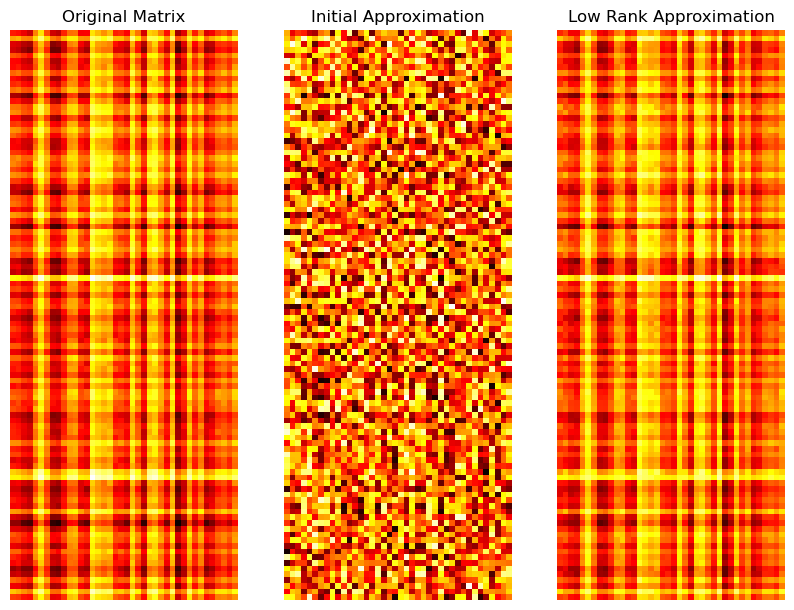

In [8]:
def show_mat(X, str, ind):
    plt.subplot(1,3,ind)
    plt.imshow(X, cmap='hot')
    plt.axis('off')
    plt.title(str)

Ar, Br = lorma_init(m, n, k)
fig = plt.figure(figsize=(10,60))
show_mat(M, 'Original Matrix', 1)
show_mat(lorma(Ar, Br), 'Initial Approximation', 2)
show_mat(lorma(A, B), 'Low Rank Approximation', 3)

<hr style="border:3px solid blue"> </hr>

# **Part 2: Movie Recommendation**

You are given data about users and their movie preferences, and you're tasked with recommending movies that the users have not seen and would like. In lecture, you learned about the [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize), which awarded 1 million dollars to a team that  significantly improved their in-house movie recommendation system.

An interesting tidbit: The team that finished second in 2008 was comprised of three Princeton undergraduates! [[article]](https://www.cs.princeton.edu/news/princeton-undergraduates-challenge-1000000-netflix-prize)

### MovieLens dataset and Pandas library    
We will be using a smaller dataset called [MovieLens](https://grouplens.org/datasets/movielens/) and will be using the [pandas](https://pandas.pydata.org/) library (specifically [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)) to work with the dataset.

Because this is the first time we're using `pandas` in the course, we'll be breaking down the steps in more detail than usual and including a few conceptual questions along the way.

For answers to questions, **answer concisely** (complete sentences are not necessary).

## Act 7: Prepare the dataset
To prepare the dataset to run LORMA on it, you'll be using the following pandas functions:
- [pd.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
- [pd.DataFrame.pivot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html)

### Act 7a: Download the MovieLens dataset (3 pts)

Use the [pd.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) to read the MovieLens dataset as a pandas DataFrame. Specifically, we'll be loading data from the `ratings.csv` file provided as part of the assignment files.

Credits: [MovieLens GitHub](https://github.com/khanhnamle1994/movielens/blob/master/ratings.csv)

In [1]:
import pandas as pd

# Act 7a: Load the MovieLens dataset into a pandas dataframe (hint: use pd.read_csv) and display the top 5 rows of the dataset
ratings_path = 'ratings.csv'
ratings_df = pd.read_csv(ratings_path) # loads the dataset as a Pandas dataframe
ratings_df.head() # displays first 5 rows of dataframe

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,46,5.0,964983815
4,0,49,5.0,964982931


## Act 7b: [`pd.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) Questions (8 pts)

**Q1: How many rows and columns are in the dataframe?**

**Q1 Answer:**

**TODO: Your answer here!**  100836 rows × 4 columns

**Q2: What are the columns in the dataframe (state each column name and your best guess as to what it stores)?**

**Q2 Answer:** 

**TODO: Your answer here!** 
userId - numeric id designating individual users
movieId - numeric id designating individual movies
rating - rating out of 5 given to each film 
timestamp - timestamp (in a.u.) of when each rating was given

**Q3: Explain the data stored in the first row (row index 0).**

**Q3 Answer:**

**TODO: Your answer here!** User 0 gave the movie with ID 0	a 4.0 at time 964982703.


### Act 7c: Convert DataFrame to matrix (4 pts)
 Convert the dataframe into a matrix where the rows (i.e. index) are users, the columns are movies, and the values are ratings.

 Hint: Use the [pd.DataFrame.pivot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html) function on the dataframe (i.e. `ratings_df.pivot(...)`)

In [10]:
ratings_matrix_df = ratings_df.pivot(columns='movieId', index='userId', values='rating') # converts dataframe to matrix form
ratings_matrix_df.head() ### your code here # displays first 5 rows of matrix_df

movieId,0,1,2,3,4,5,6,7,8,9,...,193564,193566,193570,193572,193578,193580,193582,193584,193586,193608
userId,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Act 7d: Data Preprocessing (3 pts)

**Why are there `NaN` values in the `ratings_matrix_df` dataframe?**

**Answer:** If a user $i$ does not rate a movie $j$, then the corresponding entry will be NaN.

It's important to preprocess the data to get it into the right format. Let's replace the `NaN` values with a default value of `-1`. (Hint: Use the [`pandas.DataFrame.fillna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) function).

Finally, let's convert the pandas DataFrame object into a 2D numpy array (i.e. a matrix). (Hint: Use the [`pandas.DataFrame.to_numpy`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html) function).

Tip: You can chain the above two commands together with Python dot notation (i.e. `<python object>.<function a>.<function b>`)

In [11]:
missing_value = -1
ratings_matrix_processed = ratings_matrix_df.fillna(-1).to_numpy() # imputes NaN with -1
ratings_matrix_processed # displays the full numpy as output (Note: intermediate values will be truncated with ... by default)

array([[ 4. , -1. ,  4. , ..., -1. , -1. , -1. ],
       [-1. , -1. , -1. , ..., -1. , -1. , -1. ],
       [-1. , -1. , -1. , ..., -1. , -1. , -1. ],
       ...,
       [ 2.5,  2. ,  2. , ..., -1. , -1. , -1. ],
       [ 3. , -1. , -1. , ..., -1. , -1. , -1. ],
       [ 5. , -1. , -1. , ..., -1. , -1. , -1. ]], shape=(610, 9724))

In [12]:
# check data processing step
def check_data_processing(M):
  assert(np.sum(M == -1) == 5830804)
  assert(M.shape[0] == 610)
  assert(M.shape[1] == 9724)
  assert(M.dtype == 'float64')
  assert(M[0][0] == 4)
  assert(M[0][1] == -1)
  print("Matrix passes basic data processing checks.")

check_data_processing(ratings_matrix_processed)

Matrix passes basic data processing checks.


In the next cell, we provide the last data processing step.

We create an observed matrix called `rankings_observed` that stores a 1 where we have user ratings and a 0 otherwise.


In [13]:
# Create the observed matrix with 1s where we have user ratings for a given movie and 0s otherwise
rankings_observed = np.ones_like(ratings_matrix_processed) # create matrix of 1s with same shape as ratings_matrix_processed
rankings_observed[ratings_matrix_processed == -1] = 0 # set unobserved values to 0

<hr style="border:3px solid blue"> </hr>


## Act 8: Run LORMA on the MovieLens dataset (10 pts)

Implement the following in the next code block:
1. Save a normalized version of the MovieLens data using `get_normalized_matrix`.
2. Define the parameters for LORMA (use rank = 40, epochs = 2000, eta = 10.0 for all epochs)
3. Run LORMA using the `lorma_learn` function
4. Plot losses to make sure they are decreasing.

**Hint:** Look at the function definition for `check_lorma_learn` for sample code on how to do steps 2-3.

**Note:** Running LORMA for 2000 epochs on the MovieLens dataset will take ~10 minutes in Colab.

Epoch 0: 1.0254
Epoch 10 : 1.0161
Epoch 20 : 1.0076
Epoch 30 : 0.9997
Epoch 40 : 0.992
Epoch 50 : 0.9846
Epoch 60 : 0.9771
Epoch 70 : 0.9696
Epoch 80 : 0.9618
Epoch 90 : 0.9536
Epoch 100 : 0.9449
Epoch 110 : 0.9356
Epoch 120 : 0.9254
Epoch 130 : 0.9143
Epoch 140 : 0.9021
Epoch 150 : 0.8887
Epoch 160 : 0.8741
Epoch 170 : 0.8583
Epoch 180 : 0.8414
Epoch 190 : 0.8235
Epoch 200 : 0.8047
Epoch 210 : 0.7855
Epoch 220 : 0.766
Epoch 230 : 0.7464
Epoch 240 : 0.7271
Epoch 250 : 0.7081
Epoch 260 : 0.6895
Epoch 270 : 0.6715
Epoch 280 : 0.6541
Epoch 290 : 0.6374
Epoch 300 : 0.6212
Epoch 310 : 0.6057
Epoch 320 : 0.5908
Epoch 330 : 0.5765
Epoch 340 : 0.5627
Epoch 350 : 0.5494
Epoch 360 : 0.5367
Epoch 370 : 0.5243
Epoch 380 : 0.5125
Epoch 390 : 0.501
Epoch 400 : 0.4899
Epoch 410 : 0.4792
Epoch 420 : 0.4689
Epoch 430 : 0.4589
Epoch 440 : 0.4491
Epoch 450 : 0.4397
Epoch 460 : 0.4306
Epoch 470 : 0.4217
Epoch 480 : 0.4131
Epoch 490 : 0.4048
Epoch 500 : 0.3967
Epoch 510 : 0.3888
Epoch 520 : 0.3811
Epoch 53

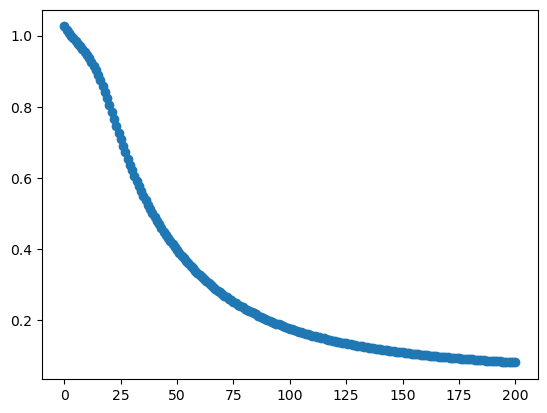

In [14]:
"""
Act 8: Run LORMA on the MovieLens dataset.
"""
# 1. Normalize the copied matrix
rankings_matrix_normalized = get_normalized_matrix(ratings_matrix_processed, rankings_observed)

# 2. Define the parameters for LORMA
k, epochs, eta = 40, 2000, 10.0 #rank, number of epochs and learning rate
etas = eta * np.ones(epochs)
params = k, epochs, etas

# 3. Run LORMA using the lorma_learn function
A, B, losses = lorma_learn(ratings_matrix_processed, rankings_observed, params)

# 4. Plot the losses to make sure they are decreasing (given)
_ = plt.plot(losses, '-o')

<hr style="border:3px solid blue"> </hr>

## Act 9: Predicting Movie Preferences

In this final section, you'll analyze the movie preferences and predicted ratings for 3 users in our dataset (user 1, 13, and 111).

We provide most of the analysis code; you'll fill in a few statements related to accessing information from the dataset.

### Act 9a: Loading movie information dataset (3 pts)

Once again, use the [pd.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) to read the MovieLens movies dataset as a pandas DataFrame. Specifically, we'll be loading data from the `movies.csv` file provided as part of the assignment files.

Credits: [MovieLens GitHub](https://github.com/khanhnamle1994/movielens/blob/master/movies.csv)

In [15]:
# Load the movies
# The data consists of rows which are movie IDs
movie_info_path = 'movies.csv' 
movie_info_df = pd.read_csv(movie_info_path) # loads the dataset as a Pandas dataframe
movie_info_df.head() # displays first 5 rows of dataframe

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,Father of the Bride Part II (1995),Comedy


### Act 9b: User Analysis (5 pts)

In the next cell, you'll analyze the user data for 3 specific users.

For each of the 3 users, we first compute the top `p` (i.e. top 10) movies that were most highly rated by that user.

Then, in the inner for loop (`for movie in top_p`), store the movie title, user rating, and movie genre in their respective variables. Finally, you'll print out that information for the top `p` movies for that user.

### Hints:
- Get the user rating from the unnormalized matrix (i.e. `ratings_matrix_processed`)
- Note that the `movie_info_df` may have more movies than the `ratings_matrix_processed` which contains our user ratings (i.e. there are some movies for which we don't have user data). Instead of directly indexing into the `movie_info_df` data frame, you should select the rows using the `movieId` field. That is, find the `movieId`'s of the `top_p` movies of a given user, and look for those movie ids in the `movie_info_df`.
- Use the [`.squeeze()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.squeeze.html) function on `movie_info_df` to get the movie title and movie genre

In [16]:
"""
We'll pick three users and see what movies they rated highly before, and what movies your model predicted.
Hopefully there is some correlation!

In this cell you will print out the top-p movies they rated most highly.
"""

# Pick three users to recommend movies to
users = [1, 13, 111]

# Let's see their tastes. Print the top-p movies they have rated highly
p = 10

# obtain the movie ids corresponding to the columns in `ratings_matrix_processed`
movie_ids = ratings_matrix_df.columns

for user in users:
    print(f"\nUser {user} liked the following:\n")

    # Sort the movies for this user in descending order based on the rating
    movie_order = np.argsort(-ratings_matrix_processed[user])
    top_p = movie_order[:p]

    # Print the top p movies
    for movie in top_p:
        # Obtain the movie title, user rating, and movie genre
        movie_id = movie_ids[movie]
        movie_info = movie_info_df[movie_info_df['movieId'] == movie_id].squeeze()
        movie_title = movie_info['title']
        user_rating = ratings_matrix_processed[user, movie]
        movie_genre = movie_info['genres']
        print("\t{:<50} rated {:.1f}  genres {:<30}".format(
            movie_title,
            user_rating,
            movie_genre)
        )



User 1 liked the following:

	The Jinx: The Life and Deaths of Robert Durst (2015) rated 5.0  genres Documentary                   
	Mad Max: Fury Road (2015)                          rated 5.0  genres Action|Adventure|Sci-Fi|Thriller
	Wolf of Wall Street, The (2013)                    rated 5.0  genres Comedy|Crime|Drama            
	Warrior (2011)                                     rated 5.0  genres Drama                         
	Inside Job (2010)                                  rated 5.0  genres Documentary                   
	Step Brothers (2008)                               rated 5.0  genres Comedy                        
	Inglourious Basterds (2009)                        rated 4.5  genres Action|Drama|War              
	Town, The (2010)                                   rated 4.5  genres Crime|Drama|Thriller          
	Good Will Hunting (1997)                           rated 4.5  genres Drama|Romance                 
	Dark Knight, The (2008)                            rated

### Act 9c: Recommended Movies (4 pts)

In the next cell, you'll print out the top `p` (i.e. top 10) movies that are predicted for the 3 users we're studying.

For each of the 3 users, we first compute the predicted ratings for that user and save the top `p` predicted movies in descending order (we set the ratings for observed movies to -infinity so that we only save the top `p` movies that haven't been rated by the user).

Then, in the inner for loop (`for movie in top_p`), store the movie title and movie genre (this should be similar to what you did in Act 9b).

In [17]:
"""
User 1 seems to like Drama and Action/Crime
User 13 seems to like Drama and Romance
User 111 seems to like Sci-Fi and Action

Now let's make our predictions on the test data and see what movies we can recommend

"""

for user in users:
    print(f"\nRecommend the following movies to User {user}\n")

    # Predict the rating for these movies by performing a matrix multiplication between the user and movie vectors
    predicted_ratings = A[user,:] @ B

    # If the movie review was observed in the matrix, set it to (-infinity) so that we don't predict it
    # We want to predict only from a set of movies which the user has not seen
    predicted_ratings[rankings_observed[user] == 1] = -np.inf

    # Choose the top_p movies
    predicted_movie_order = np.argsort(-predicted_ratings)
    top_p = predicted_movie_order[:p]

    # Print the recommended movies
    for movie in top_p:
      movie_id = movie_ids[movie]
      movie_info = movie_info_df[movie_info_df['movieId'] == movie_id].squeeze()
      movie_title = movie_info['title']
      movie_genre = movie_info['genres']
      user_rating = ratings_matrix_processed[user, movie] # should be -1 as recommended movies are unobserved
      print("\t{:<60} genres {:<30}".format(movie_title[:60], # cap length of movie title to 60 char
                                            movie_genre))


Recommend the following movies to User 1

	Dumb & Dumber (Dumb and Dumber) (1994)                       genres Adventure|Comedy              
	Cable Guy, The (1996)                                        genres Comedy|Thriller               
	Austin Powers: The Spy Who Shagged Me (1999)                 genres Action|Adventure|Comedy       
	Graduate, The (1967)                                         genres Comedy|Drama|Romance          
	Aristocats, The (1970)                                       genres Animation|Children            
	Kid, The (2000)                                              genres Comedy|Fantasy                
	Eat Drink Man Woman (Yin shi nan nu) (1994)                  genres Comedy|Drama|Romance          
	Jurassic Park (1993)                                         genres Action|Adventure|Sci-Fi|Thriller
	Annie Hall (1977)                                            genres Comedy|Romance                
	This Is Spinal Tap (1984)                             

### ACT 9d: Answer the following question in the cell below (10 pts)

**Question:** Do you see any correlation between the top rated movies (Act 9b) and the top predicted movies (Act 9c)?

**For each user**, answer the question and briefly explain your reasoning in **1 sentence (total 3 sentences; 1 per user).**

For each user,
- If yes, briefly explain the correlation you observe.
- If no, briefly explain why you don't believe there's a correlation between their top rated movies and top predicted movies.

**Note:** The correlation, if there's any, may be weak.

**Answer:**

**TODO: Your answer here!** 

User 1 primarily liked Action/Crime and Drama films; a couple of Drama and Action films have been recommended. While user 1 had originally liked a couple of comedy films, the set of recommended films are disproportionately comedy films. Overall, there is a weak correlation between the top rated and predicted movies.

User 13 primarily liked Drama, Romance and Western films; some Romance but primarily Drama films have been recommended. A large portion of the Drama films recommended are Sci-Fi and Thriller, which does not seem to be of user 13's taste. Again, overall, there is a correlation between the top rated and recommended films. 

User 111 primarily liked Sci-Fi, Action/Adventure, IMAX films; many Action, Adventure and Sci-Fi films have been recommended. Although no IMAX films were recommended, there is overall a good correlation between the top rated and recommended films. 